# **Cnn**

In [1]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import os
import tensorflow as tf
import keras
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

#----------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_dir = "/content/train/" # Directory containing the training data
test_dir = "/content/test/"  # Directory containing the validation data

def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [ ]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

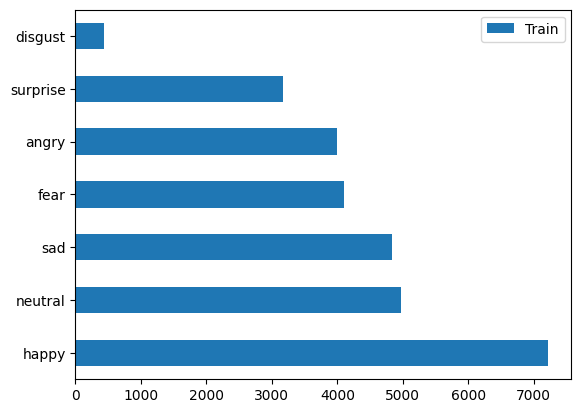

In [ ]:
Train_Count.plot(kind='barh')

<Axes: >

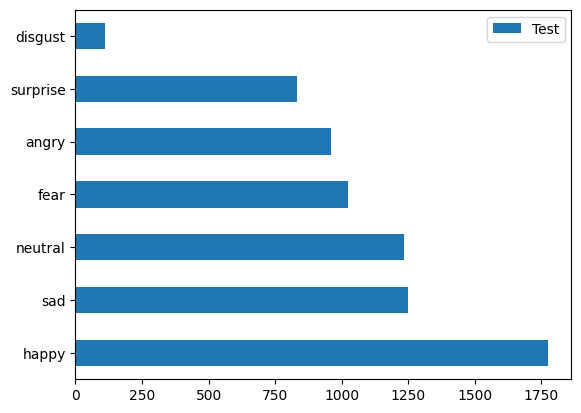

In [ ]:
Test_Count.plot(kind='barh')

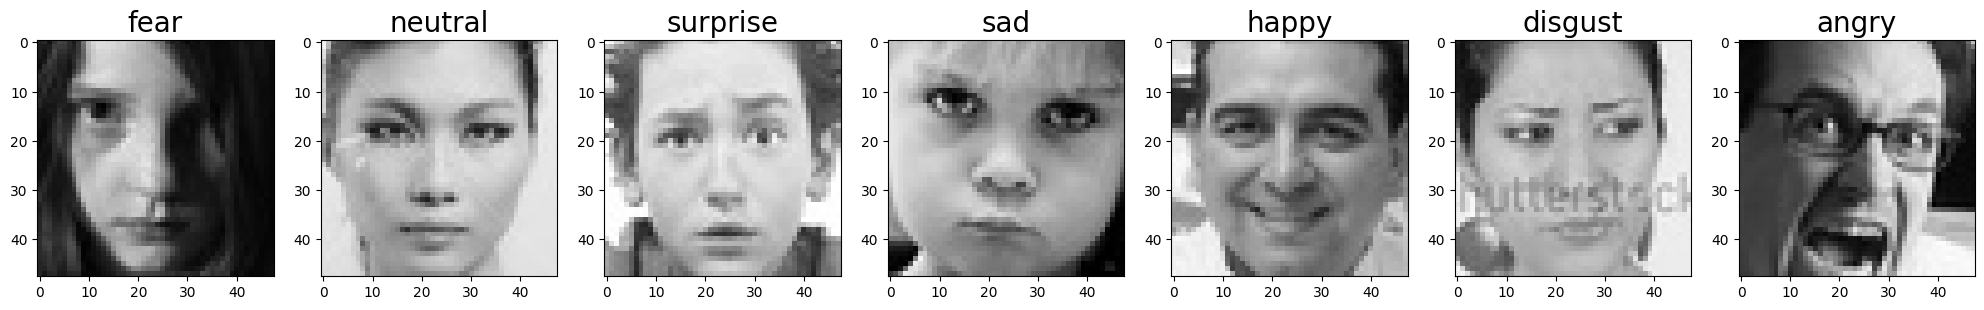

In [ ]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '/content/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

In [ ]:
img_shape = 48
batch_size = 64
train_data_path = '/content/train/'
test_data_path = '/content/test/'

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
def Create_CNN_Model():

    model = Sequential()

    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))


    #Output
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(7,activation='softmax'))


    return model

In [ ]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                        

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [14]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50
448/448 [==============================] - 61s 105ms/step - loss: 2.0560 - accuracy: 0.2022 - val_loss: 1.8449 - val_accuracy: 0.2400 - lr: 0.0010
Epoch 2/50
448/448 [==============================] - 43s 96ms/step - loss: 1.7740 - accuracy: 0.2798 - val_loss: 1.6786 - val_accuracy: 0.3407 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - 45s 101ms/step - loss: 1.6309 - accuracy: 0.3559 - val_loss: 1.5751 - val_accuracy: 0.3901 - lr: 0.0010
Epoch 4/50
176/448 [==========>...................] - ETA: 24s - loss: 1.5539 - accuracy: 0.3910

KeyboardInterrupt: 

In [ ]:
CNN_Score = CNN_Model.evaluate(test_data)

print("Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

In [ ]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

  #plt.tight_layout()

In [ ]:
plot_curves(CNN_history)

In [ ]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

In [ ]:
test_data.class_indices

Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Your confusion matrix generation
cm = confusion_matrix(test_data.labels, CNN_Predictions)

# Emotion classes
Emotion_Classes = ['Angry',
                   'Disgust',
                   'Fear',
                   'Happy',
                   'Neutral',
                   'Sad',
                   'Surprise']

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')

# Set axis labels
ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# Set the tick labels
ax.set_xticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_yticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_xticklabels(Emotion_Classes, rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(Emotion_Classes, rotation=0, fontsize=12, fontweight='bold')

# Show the plot
plt.show()

In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# **ResNet50**

In [ ]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = '/content/train'
test_data_path = '/content/test'

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

In [8]:
import cv2
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten






<Axes: >

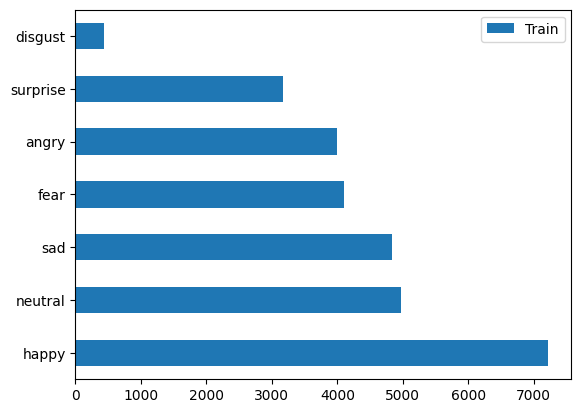

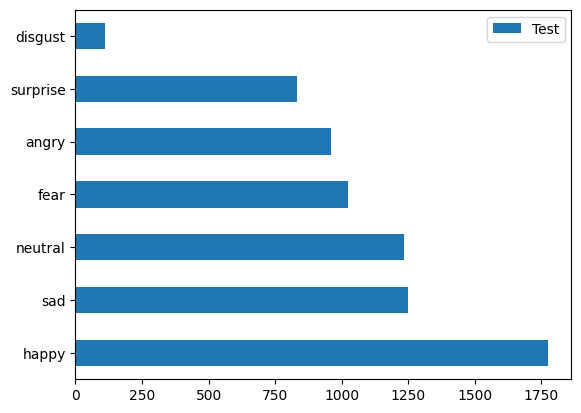

In [9]:
# Directory paths
train_dir = "/content/train/"
test_dir = "/content/test/"

# Function to count classes
def Classes_Count(path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df

# Counting classes
Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

pd.concat([Train_Count, Test_Count], axis=1)
Train_Count.plot(kind='barh')
Test_Count.plot(kind='barh')


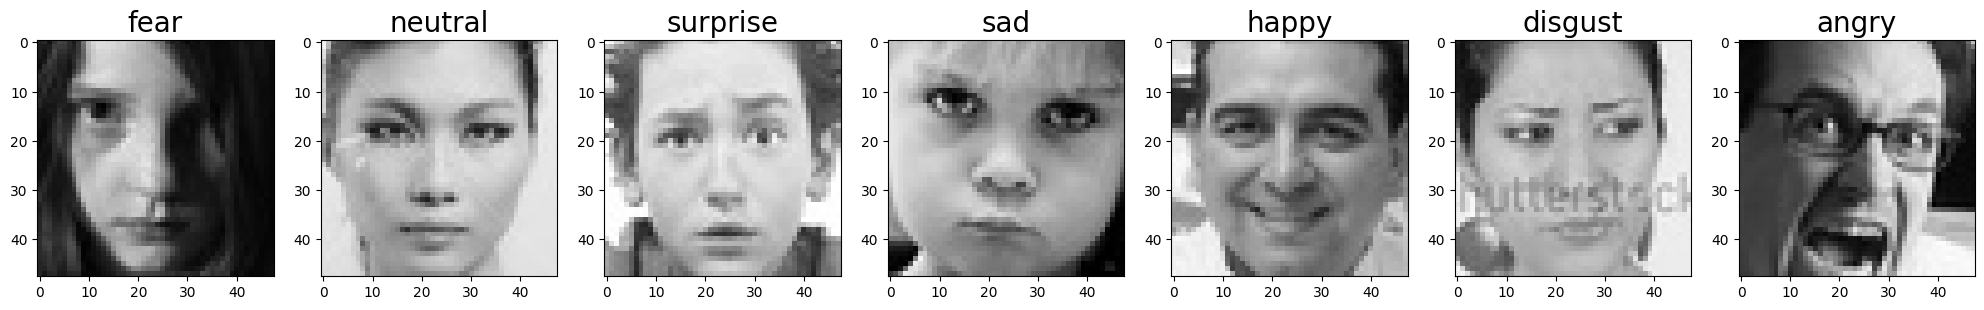

In [10]:
# Displaying sample images
plt.style.use('default')
plt.figure(figsize=(25, 8))
image_count = 1
BASE_URL = '/content/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize=20)


In [11]:
# Image pre-processing and augmentation
img_shape = 75
batch_size = 64
train_data_path = '/content/train/'
test_data_path = '/content/test/'

train_preprocessor = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_preprocessor = ImageDataGenerator(rescale=1 / 255.)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
# Freeze all layers except the last 50 in InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_shape, img_shape, 3))
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Define InceptionV3-based model
def Create_InceptionV3_Model():
    model = Sequential([
        base_model,
        Dropout(0.25),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

InceptionV3_Model = Create_InceptionV3_Model()
InceptionV3_Model.summary()

# Compile the model
InceptionV3_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_path = "InceptionV3_Model_Checkpoint"
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00005, verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

# Train the model
InceptionV3_history = InceptionV3_Model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,
    batch_size=batch_size,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 2048)        0         
                                                                 
 batch_normalization_285 (B  (None, 1, 1, 2048)        8192      
 atchNormalization)                                              
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                131136    
                                                                 
 batch_normalization_286 (B  (None, 64)                256       
 atchNormalization)                                   

113/113 [==============================] - 6s 50ms/step - loss: 1.5446 - accuracy: 0.4029
Test Loss: 1.54458
Test Accuracy: 40.29%


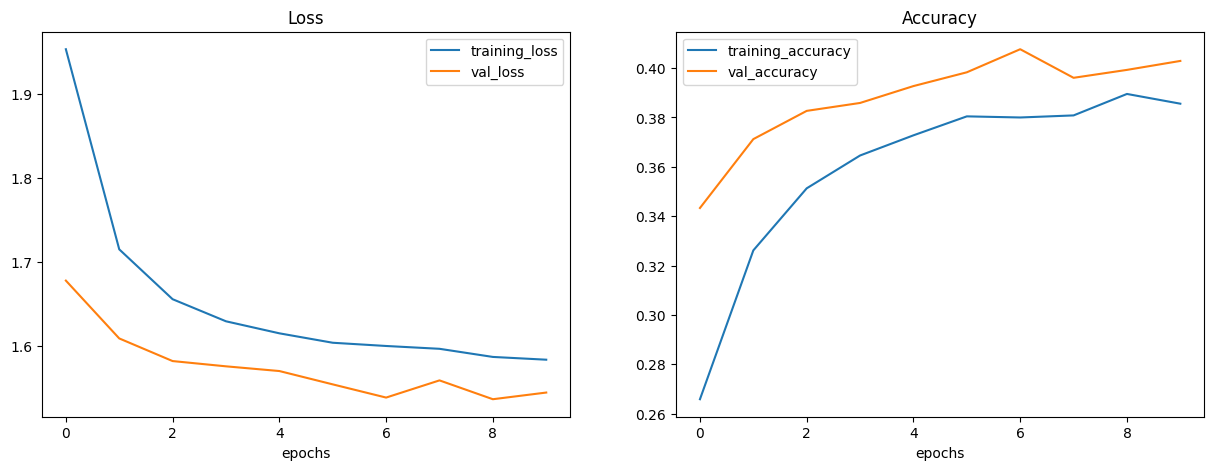

In [10]:
# Evaluating the model
InceptionV3_Score = InceptionV3_Model.evaluate(test_data)
print("Test Loss: {:.5f}".format(InceptionV3_Score[0]))
print("Test Accuracy: {:.2f}%".format(InceptionV3_Score[1] * 100))

# Plotting training history
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

plot_curves(InceptionV3_history)


113/113 [==============================] - 6s 41ms/step


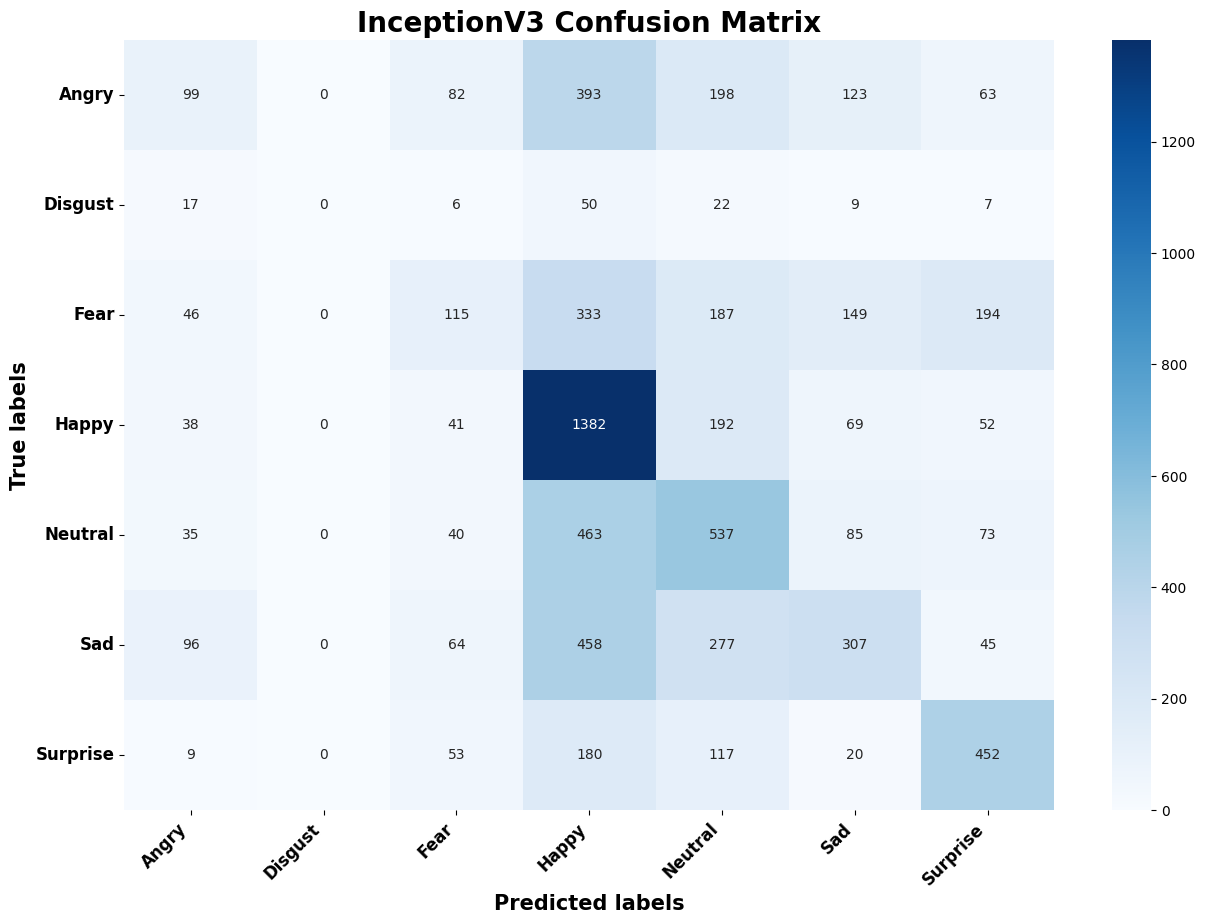

In [11]:
# Confusion matrix
CNN_Predictions = InceptionV3_Model.predict(test_data)
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_data.labels, CNN_Predictions)
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('InceptionV3 Confusion Matrix', fontsize=20, fontweight='bold')
ax.set_xticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_yticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_xticklabels(Emotion_Classes, rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(Emotion_Classes, rotation=0, fontsize=12, fontweight='bold')
plt.show()


Found 7178 images belonging to 7 classes.


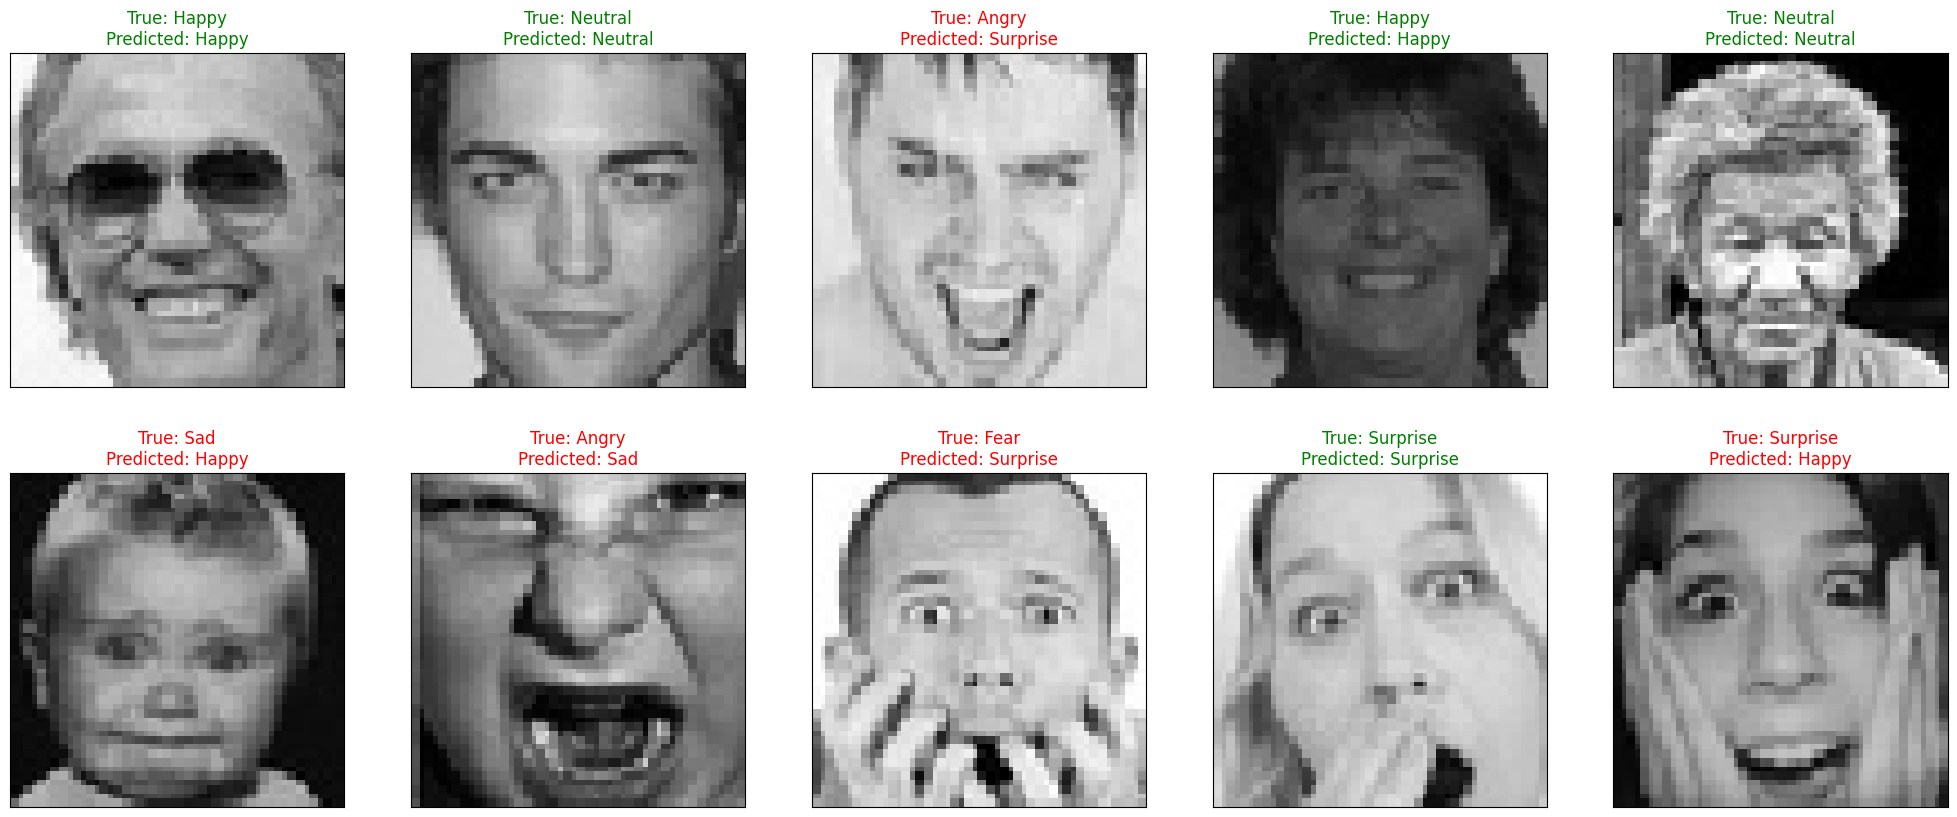

<Figure size 640x480 with 0 Axes>

In [12]:
# Displaying random test images with predictions
test_preprocessor = ImageDataGenerator(rescale=1 / 255.)

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size
)

Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(InceptionV3_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))

    ax.imshow(Random_Img)
    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()
